In [1]:
import os
import os.path as osp
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
import torch
import cv2
import albumentations as albu

In [3]:
def parse_filename(filename):
    parts = filename.split('_')
    if len(parts) == 5:
        exp = parts[0]
        pacient = parts[1]
        passage = int(parts[2][1:])  # Extracting the number and converting to integer
        channel = parts[3]
        number = int(parts[4].split('.')[0])  # Removing the file extension and converting to integer
    elif len(parts) == 7:
        exp = parts[0]
        pacient = parts[1]
        passage = int(parts[2][1:])  # Extracting the number and converting to integer
        channel = parts[5]
        number = int(parts[6].split('.')[0])  # Removing the file extension and converting to integer
        
    return exp, pacient, passage, channel, number

In [4]:
def get_squares(orig_size, square_size, border, ):
    w, h = orig_size
    square_w, square_h = square_size

    # square_w_with_border = square_w + 2 * border
    # square_h_with_border = square_h + 2 * border
    # square_with_border_size = (square_w_with_border, square_h_with_border)

    square_w_num, square_h_num = int(np.ceil(w / square_w)), int(np.ceil(h / square_h))
    full_size = (square_w * square_w_num, square_h * square_h_num)
    full_size_with_borders = (full_size[0] + 2 * border, full_size[1] + 2 * border)

    squares = []
    for start_w_idx in range(square_w_num):
        start_w = start_w_idx * square_w
        end_w = (start_w_idx + 1) * square_w

        for start_h_idx in range(square_h_num):
            start_h = start_h_idx * square_h
            end_h = (start_h_idx + 1) * square_h

            square_coords = [start_w,
                             start_h,
                             end_w,
                             end_h]
            square_with_borders_coords = [start_w,
                                          start_h,
                                          end_w + 2 * border,
                                          end_h + 2 * border]
            square_with_borders_coords_rev = [start_w + border,
                                              start_h + border,
                                              end_w + border,
                                              end_h + border]

            square_info_dict = dict(w=start_w_idx,
                                    h=start_h_idx,
                                    square_coords=square_coords,
                                    square_with_borders_coords=square_with_borders_coords,
                                    square_with_borders_coords_rev=square_with_borders_coords_rev)
            squares.append(square_info_dict)

    return full_size, full_size_with_borders, squares

In [5]:
def split_on_squares(image, squares, param_name):
    img_sq_list = []
    for sq in squares:
        img_sq = image[:, sq[param_name][1]:sq[param_name][3], sq[param_name][0]:sq[param_name][2]].copy()
        img_sq_list.append(img_sq)

    return img_sq_list
    
def split_image(image, full_size, squares, border):
    c = image.shape[0]

    image_with_borders = []
    for c_idx in range(c):
        image_resized_cur_c = cv2.resize(image[c_idx], full_size, interpolation=cv2.INTER_NEAREST)
        image_with_borders_cur_c = cv2.copyMakeBorder(image_resized_cur_c, border, border, border, border,
                                                      cv2.BORDER_REFLECT, None)
        image_with_borders.append(image_with_borders_cur_c)
    image_with_borders = np.stack(image_with_borders)

    img_sq_list = split_on_squares(image_with_borders, squares, 'square_with_borders_coords')

    return image_with_borders, img_sq_list


def unsplit_image(img_sq_list, squares, param_name, border):
    w_num, h_num = squares[-1]['w'] + 1, squares[-1]['w'] + 1
    square_size = (squares[0]['square_coords'][2], squares[0]['square_coords'][3])
    result_size = (img_sq_list[0].shape[0], square_size[0] * w_num, square_size[1] * h_num)
    result = np.zeros(result_size)
    for sq, img_sq in zip(squares, img_sq_list):
        result[:, sq[param_name][1]:sq[param_name][3], sq[param_name][0]:sq[param_name][2]] = img_sq[:,
                                                                                              border:square_size[
                                                                                                         0] + border,
                                                                                              border:square_size[
                                                                                                         1] + border]
    return result


def draw_square(image, sq, color):
    for c_idx in range(len(color)):
        image[c_idx][sq[1]:sq[3], sq[0]] = color[c_idx]
        image[c_idx][sq[1], sq[0]:sq[2]] = color[c_idx]
        image[c_idx][sq[1]:sq[3], sq[2]] = color[c_idx]
        image[c_idx][sq[3], sq[0]:sq[2]] = color[c_idx]

In [6]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        # albu.PadIfNeeded(384, 480, always_apply=True, border_mode=0),
        # albu.Resize(384, 480)
    ]
    return albu.Compose(test_transform, is_check_shapes=False)


def to_tensor(x, **kwargs):
    return x.astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform, is_check_shapes=False)

In [7]:
R, G, B = 0, 1, 2
img_dir = 'datasets/MSC/cropped_yo'
fn_list = [v for v in os.listdir(img_dir) if v.endswith('.png')]
fn_list.sort()

fn_dict = dict()
for fn in tqdm(fn_list):
    exp, pacient, passage, channel, number = parse_filename(fn)
    if (exp, number) not in fn_dict.keys():
        fn_dict[(exp, number)] = dict(pacient=pacient, passage=passage)
    fn_dict[(exp, number)][channel] = fn
# pprint(fn_dict)

100%|█████████████████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 853415.17it/s]


In [8]:
mode = 'BG'

npy_mask_dir = osp.join('cropped_yo', mode, '1class')

G_ids = list()
dataset = list()
dataset_info  = list()
idx = 0

for k, info in tqdm(fn_dict.items()):
    exp, n = k
    pacient = info['pacient']
    passage = info['passage']

    img = np.zeros((2, 1024, 1024), dtype=np.float32)
    if mode == 'BR':
        img[0] = plt.imread(osp.join(img_dir, info['B']))[..., B]
        img[1] = plt.imread(osp.join(img_dir, info['R']))[..., R]

        with open(osp.join(npy_mask_dir, f"{exp}_{info['pacient']}_p{info['passage']}_{n}"+'.npy'), 'rb') as f:
            img_2 = np.load(f)
            img = np.stack([img[0], img[1], img_2[1], img_2[0]], axis=0)
        dataset.append(img)
        dataset_info.append([k, info])

    elif mode == 'BG':
        if 'G' in info.keys():
            img[0] = plt.imread(osp.join(img_dir, info['B']))[..., B]
            img[1] = plt.imread(osp.join(img_dir, info['G']))[..., G]

            with open(osp.join(npy_mask_dir, f"{exp}_{info['pacient']}_p{info['passage']}_{n}"+'.npy'), 'rb') as f:
                img_2 = np.load(f)
                img = np.stack([img[0], img[1], img_2[1], img_2[0]], axis=0)
            dataset.append(img)
            dataset_info.append([k, info])
dataset = np.stack(dataset)
print(dataset.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:04<00:00, 52.85it/s]


(252, 4, 1024, 1024)


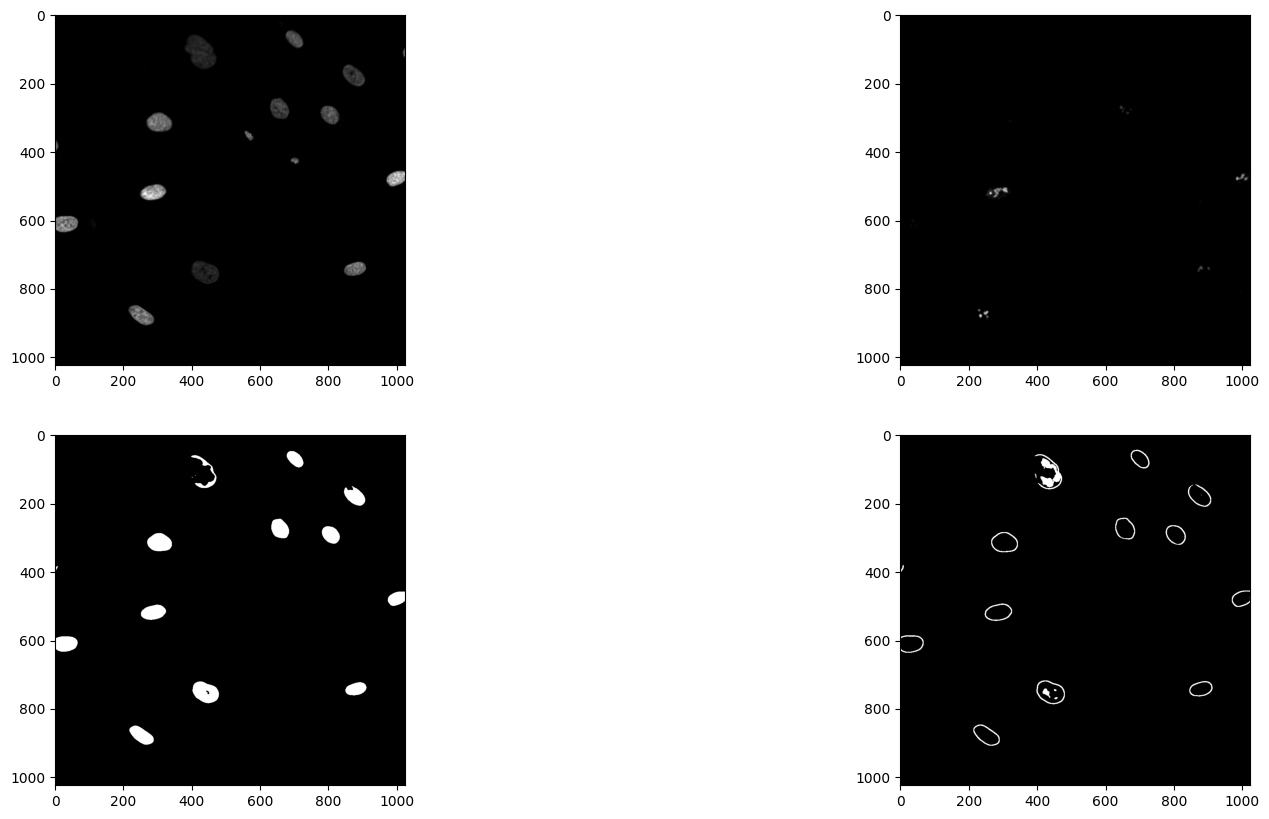

In [9]:
idx = 10
cmap = 'grey'
figsize = (20, 10)

fig, ax = plt.subplots(2,2, figsize=figsize)
img = dataset[idx]
ax[0][0].imshow(img[0], cmap=cmap)
ax[0][1].imshow(img[1], cmap=cmap)
ax[1][0].imshow(img[2], cmap=cmap)
ax[1][1].imshow(img[3], cmap=cmap)

In [10]:
model_load_fp = os.path.join('out', 'MSC_filtered_mcnpy', 'Unet_timm-efficientnet-b6_4c_20240507_151050', 'best_model.pth')
device = 'cuda'
model = torch.load(model_load_fp).to(device)

In [11]:
border = 64
full_size, full_size_with_borders, squares = get_squares((dataset.shape[-2], dataset.shape[-1]), (256, 256), border)

preprocessing_fn = None
preprocessing = get_preprocessing(preprocessing_fn)
augmentation = get_validation_augmentation()

In [12]:
res_dir = osp.join('cropped_yo', mode, '3class')
os.makedirs(res_dir, exist_ok=True)

for idx, img in tqdm(enumerate(dataset[:])):
    (exp, n), info = dataset_info[idx]
    img_list = list()
    pred_masks = list()
    _, img_sq_list = split_image(img, full_size, squares, border)
    for img_sq, sq in zip(img_sq_list, squares):
        if augmentation:
            sample = augmentation(image=img_sq[0:2].astype('float32'), )
            img_sq[0:2] = sample['image']

        if preprocessing:
            sample = preprocessing(image=img_sq[0:2].astype('float32'))
            img_sq[0:2] = sample['image']
        in_img = torch.Tensor([img_sq]).to(device)
        img_list.append(img_sq)
        pred_masks.append(model(in_img).detach().squeeze().cpu().numpy().round())
    restored_img = unsplit_image(img_list, squares, 'square_coords',border).astype(np.uint8)
    restored_pr = unsplit_image(pred_masks, squares, 'square_coords', border).astype(np.uint8)

    pr_img = np.zeros((1024, 1024, 3), dtype=np.uint8)
    pr_img[..., 0][restored_pr[0]==1] = 255
    pr_img[..., 1][restored_pr[2]==1] = 255
    pr_img[..., 2][restored_pr[3]==1] = 255

    pr_img[..., 0][restored_pr[1]==1] = 255
    pr_img[..., 1][restored_pr[1]==1] = 255
    pr_img[..., 2][restored_pr[1]==1] = 255

    pr_img.clip(0, 255)

    res_name = f"{exp}_{info['pacient']}_p{info['passage']}_{n}"
    plt.imsave(osp.join(res_dir, res_name+'.png'), pr_img)

    with open(osp.join(res_dir, res_name+'.npy'), 'wb') as f:
        np.save(f, restored_pr)

0it [00:00, ?it/s]/tmp/ipykernel_1227133/3448823649.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  in_img = torch.Tensor([img_sq]).to(device)
252it [05:01,  1.19s/it]
